In [1]:
import torch
import torch.nn as nn
import numpy as np
import torchvision
from torchvision import transforms
import time
from torch.utils.data import TensorDataset, DataLoader

In [2]:
# minist数据集
mnist_train = torchvision.datasets.MNIST(root='~/Datasets/MNIST',train=True, download=True, transform=transforms.ToTensor())
mnist_test = torchvision.datasets.MNIST(root='~/Datasets/MNIST',train=False, transform=transforms.ToTensor())
# 通过DataLoader 读取小批量数据样本
batch_size = 128
train_iter = DataLoader(mnist_train, batch_size=batch_size, shuffle=True,num_workers=0)
test_iter = DataLoader(mnist_test, batch_size=batch_size, shuffle=False,num_workers=0)

In [3]:
# 绘图函数
import matplotlib.pyplot as plt
def draw_loss(train_loss, test_acc):
    x = range(len(train_loss))
    # 创建一个1行2列的图像布局
    plt.figure(figsize=(10, 5))
    # 在第一个子图中绘制训练损失
    plt.subplot(1, 2, 1)
    plt.plot(x, train_loss, label="Train Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    # 在第二个子图中绘制测试精度
    plt.subplot(1, 2, 2)
    plt.plot(x, test_acc, color='r', label="Test Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [4]:
# 测试准确率评价函数
def evaluate_accuracy(data_iter, model):
    acc_sum, n= 0.0, 0
    for X, y in data_iter:
        result = model.forward(X)
        acc_sum += (result.argmax(dim=1) == y).float().sum().item()
        n += y.shape[0]
    return acc_sum / n

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256
        self.W1 = nn.Parameter(torch.tensor(np.random.normal(0, 0.01, size=(num_hiddens1, num_inputs)), dtype=torch.float, requires_grad=True))
        self.b1 = nn.Parameter(torch.zeros(num_hiddens1, requires_grad=True))
        self.W2 = nn.Parameter(torch.tensor(np.random.normal(0, 0.01, size=(num_hiddens2, num_hiddens1)), dtype=torch.float, requires_grad=True))
        self.b2 = nn.Parameter(torch.zeros(num_hiddens2, requires_grad=True))
        self.W3 = nn.Parameter(torch.tensor(np.random.normal(0, 0.01, size=(num_outputs, num_hiddens2)), dtype=torch.float, requires_grad=True))
        self.b3 = nn.Parameter(torch.zeros(num_outputs, requires_grad=True))
        self.params = [self.W1, self.b1, self.W2, self.b2, self.W3, self.b3]
        # 定义模型结构
        self.input_layer = lambda x: x.view(x.shape[0], -1)
        self.hidden_layer1 = lambda x: torch.matmul(x, self.W1.t()) + self.b1
        self.hidden_layer2 = lambda x: torch.matmul(x, self.W2.t()) + self.b2
        self.output_layer = lambda x: torch.matmul(x, self.W3.t()) + self.b3
        
    # 定义𝐿2范数惩罚项
    def l2_penalty(self):
        return (self.W1**2).sum() / 2 + (self.W2**2).sum() / 2 + (self.W3**2).sum() / 2
    
    def forward(self, x):
        # 定义前向传播
        x = self.input_layer(x)
        x = nn.ReLU()(self.hidden_layer1(x))
        x = nn.ReLU()(self.hidden_layer2(x))
        x = self.output_layer(x)
        return x

In [6]:
# 训练函数
def train(net, train_iter, loss_func, epochs, optimizer, lambd):
    train_loss_list = []
    test_acc_list = []
    time_start = time.time()
    for epoch in range(epochs):
        train_l_sum, train_acc_sum, n, c = 0.0,0.0, 0,0
        for X,y in train_iter:
            y_hat = net.forward(X)
            l = loss_func(y_hat,y) + lambd * net.l2_penalty()
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.shape[0]
            c += 1
        test_acc = evaluate_accuracy(test_iter, net)
        train_loss_list.append(train_l_sum / c)
        test_acc_list.append(test_acc)
        print('epoch %d, train loss %.4f, train acc %.3f, test acc %.3f' % (epoch + 1, train_l_sum / c, train_acc_sum / n, test_acc))
    print("time spend: %.6f second" % (time.time() - time_start))
    print('L2 norm of weights:', torch.norm(net.W1).item() + torch.norm(net.W2).item() + torch.norm(net.W3).item())
    draw_loss(train_loss_list, test_acc_list)

epoch 1, train loss 1.4563, train acc 0.513, test acc 0.862
epoch 2, train loss 0.3922, train acc 0.886, test acc 0.906
epoch 3, train loss 0.2753, train acc 0.921, test acc 0.937
epoch 4, train loss 0.2043, train acc 0.942, test acc 0.952
epoch 5, train loss 0.1591, train acc 0.954, test acc 0.959
epoch 6, train loss 0.1311, train acc 0.962, test acc 0.966
epoch 7, train loss 0.1099, train acc 0.968, test acc 0.968
epoch 8, train loss 0.0944, train acc 0.972, test acc 0.971
epoch 9, train loss 0.0827, train acc 0.976, test acc 0.971
epoch 10, train loss 0.0722, train acc 0.980, test acc 0.972
epoch 11, train loss 0.0645, train acc 0.981, test acc 0.973
epoch 12, train loss 0.0582, train acc 0.983, test acc 0.974
epoch 13, train loss 0.0513, train acc 0.986, test acc 0.978
epoch 14, train loss 0.0457, train acc 0.987, test acc 0.977
epoch 15, train loss 0.0411, train acc 0.988, test acc 0.977
epoch 16, train loss 0.0372, train acc 0.990, test acc 0.978
epoch 17, train loss 0.0331, trai

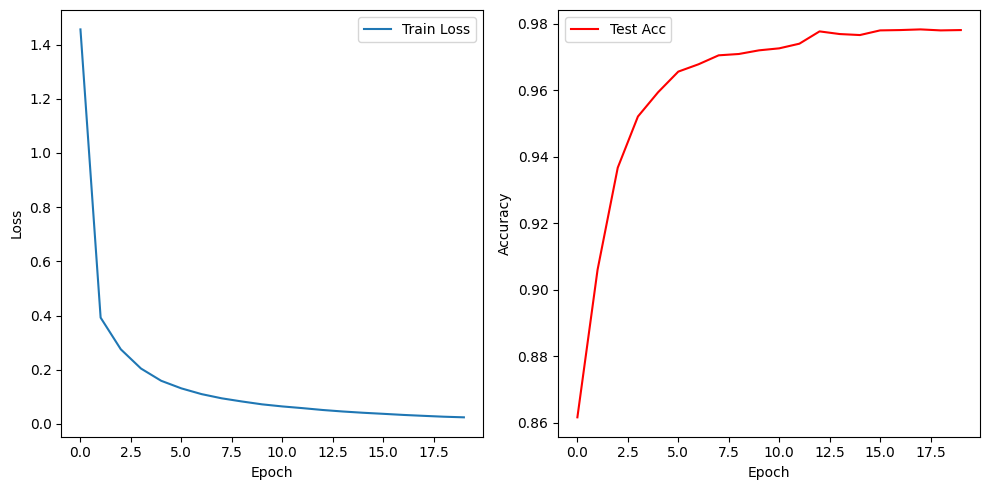

In [7]:
epochs = 20
lr = 0.1
loss = nn.CrossEntropyLoss()
net = Net()
optimizer = torch.optim.SGD(net.parameters(), lr)
train(net, train_iter, loss, epochs, optimizer, 0)

epoch 1, train loss 1.7573, train acc 0.424, test acc 0.814
epoch 2, train loss 0.7148, train acc 0.858, test acc 0.887
epoch 3, train loss 0.6112, train acc 0.895, test acc 0.907
epoch 4, train loss 0.5717, train acc 0.912, test acc 0.922
epoch 5, train loss 0.5511, train acc 0.921, test acc 0.927
epoch 6, train loss 0.5402, train acc 0.928, test acc 0.930
epoch 7, train loss 0.5332, train acc 0.931, test acc 0.936
epoch 8, train loss 0.5264, train acc 0.935, test acc 0.937
epoch 9, train loss 0.5235, train acc 0.937, test acc 0.940
epoch 10, train loss 0.5208, train acc 0.938, test acc 0.938
epoch 11, train loss 0.5185, train acc 0.940, test acc 0.941
epoch 12, train loss 0.5164, train acc 0.941, test acc 0.937
epoch 13, train loss 0.5146, train acc 0.942, test acc 0.945
epoch 14, train loss 0.5132, train acc 0.942, test acc 0.942
epoch 15, train loss 0.5124, train acc 0.943, test acc 0.946
epoch 16, train loss 0.5118, train acc 0.944, test acc 0.945
epoch 17, train loss 0.5105, trai

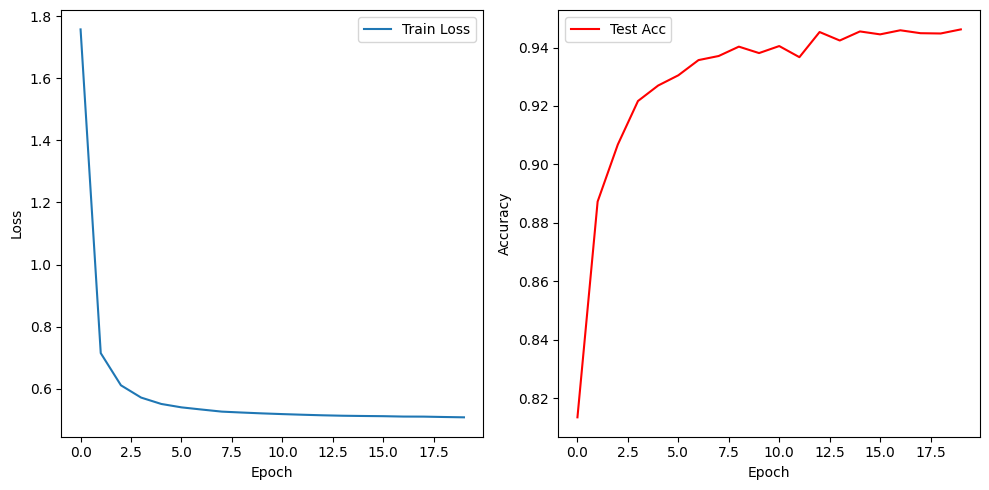

In [8]:
net = Net()
optimizer = torch.optim.SGD(net.parameters(), lr)
train(net, train_iter, loss, epochs, optimizer, 0.01)

epoch 1, train loss 1.9231, train acc 0.394, test acc 0.778
epoch 2, train loss 0.9464, train acc 0.817, test acc 0.852
epoch 3, train loss 0.8358, train acc 0.867, test acc 0.880
epoch 4, train loss 0.8023, train acc 0.883, test acc 0.883
epoch 5, train loss 0.7892, train acc 0.890, test acc 0.897
epoch 6, train loss 0.7796, train acc 0.895, test acc 0.888
epoch 7, train loss 0.7730, train acc 0.900, test acc 0.906
epoch 8, train loss 0.7676, train acc 0.902, test acc 0.906
epoch 9, train loss 0.7642, train acc 0.905, test acc 0.907
epoch 10, train loss 0.7611, train acc 0.907, test acc 0.910
epoch 11, train loss 0.7597, train acc 0.907, test acc 0.910
epoch 12, train loss 0.7572, train acc 0.909, test acc 0.909
epoch 13, train loss 0.7560, train acc 0.910, test acc 0.911
epoch 14, train loss 0.7543, train acc 0.909, test acc 0.915
epoch 15, train loss 0.7529, train acc 0.911, test acc 0.917
epoch 16, train loss 0.7510, train acc 0.912, test acc 0.911
epoch 17, train loss 0.7520, trai

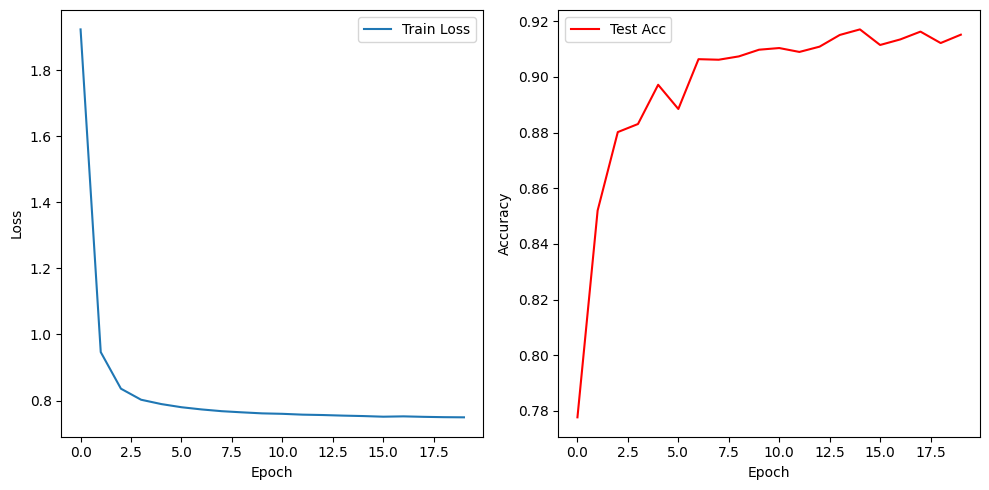

In [9]:
net = Net()
optimizer = torch.optim.SGD(net.parameters(), lr)
train(net, train_iter, loss, epochs, optimizer, 0.02)

epoch 1, train loss 2.4433, train acc 0.113, test acc 0.114
epoch 2, train loss 2.3030, train acc 0.112, test acc 0.114
epoch 3, train loss 2.3015, train acc 0.112, test acc 0.114
epoch 4, train loss 2.3014, train acc 0.112, test acc 0.114
epoch 5, train loss 2.3014, train acc 0.112, test acc 0.114
epoch 6, train loss 2.3013, train acc 0.112, test acc 0.114
epoch 7, train loss 2.3014, train acc 0.112, test acc 0.114
epoch 8, train loss 2.3014, train acc 0.112, test acc 0.114
epoch 9, train loss 2.3014, train acc 0.112, test acc 0.114
epoch 10, train loss 2.3014, train acc 0.112, test acc 0.114
epoch 11, train loss 2.3014, train acc 0.112, test acc 0.114
epoch 12, train loss 2.3014, train acc 0.112, test acc 0.114
epoch 13, train loss 2.3014, train acc 0.112, test acc 0.114
epoch 14, train loss 2.3014, train acc 0.112, test acc 0.114
epoch 15, train loss 2.3014, train acc 0.112, test acc 0.114
epoch 16, train loss 2.3014, train acc 0.112, test acc 0.114
epoch 17, train loss 2.3014, trai

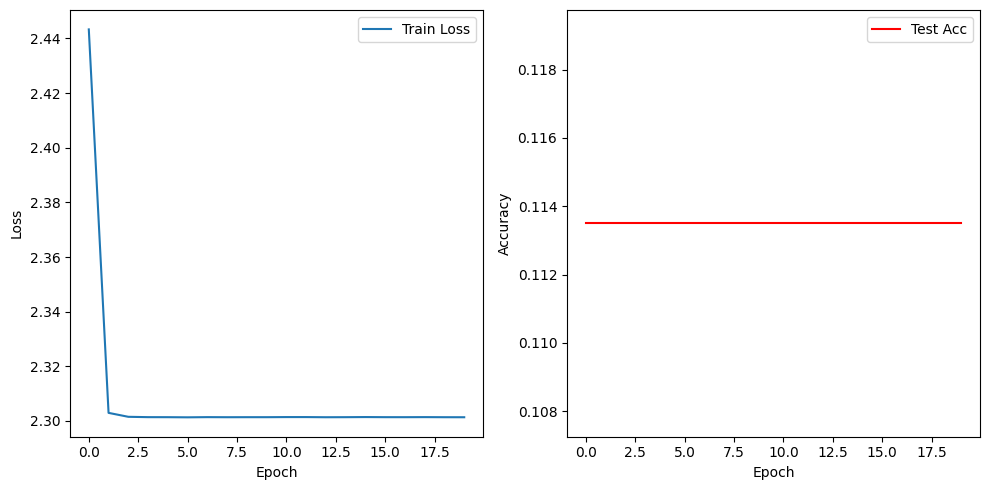

In [10]:
net = Net()
optimizer = torch.optim.SGD(net.parameters(), lr)
train(net, train_iter, loss, epochs, optimizer, 0.05)

epoch 1, train loss 2.4453, train acc 0.113, test acc 0.114
epoch 2, train loss 2.3014, train acc 0.112, test acc 0.114
epoch 3, train loss 2.3014, train acc 0.112, test acc 0.114
epoch 4, train loss 2.3014, train acc 0.112, test acc 0.114
epoch 5, train loss 2.3014, train acc 0.112, test acc 0.114
epoch 6, train loss 2.3014, train acc 0.112, test acc 0.114
epoch 7, train loss 2.3014, train acc 0.112, test acc 0.114
epoch 8, train loss 2.3014, train acc 0.112, test acc 0.114
epoch 9, train loss 2.3014, train acc 0.112, test acc 0.114
epoch 10, train loss 2.3014, train acc 0.112, test acc 0.114
epoch 11, train loss 2.3014, train acc 0.112, test acc 0.114
epoch 12, train loss 2.3014, train acc 0.112, test acc 0.114
epoch 13, train loss 2.3014, train acc 0.112, test acc 0.114
epoch 14, train loss 2.3013, train acc 0.112, test acc 0.114
epoch 15, train loss 2.3014, train acc 0.112, test acc 0.114
epoch 16, train loss 2.3013, train acc 0.112, test acc 0.114
epoch 17, train loss 2.3015, trai

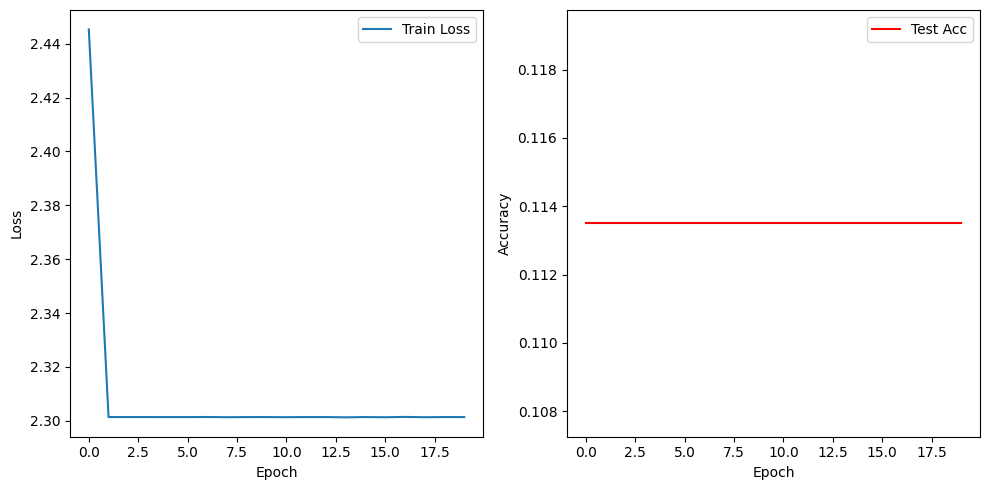

In [11]:
net = Net()
optimizer = torch.optim.SGD(net.parameters(), lr)
train(net, train_iter, loss, epochs, optimizer, 0.1)

In [12]:
# 使用torch.nn实现L2正则化，要修改训练函数
def train1(net, train_iter, loss_func, epochs, optimizer):
    train_loss_list = []
    test_acc_list = []
    time_start = time.time()
    for epoch in range(epochs):
        train_l_sum, train_acc_sum, n, c = 0.0,0.0, 0,0
        for X,y in train_iter:
            y_hat = net.forward(X)
            l = loss_func(y_hat,y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.shape[0]
            c += 1
        test_acc = evaluate_accuracy(test_iter, net)
        train_loss_list.append(train_l_sum / c)
        test_acc_list.append(test_acc)
        print('epoch %d, train loss %.4f, train acc %.3f, test acc %.3f' % (epoch + 1, train_l_sum / c, train_acc_sum / n, test_acc))
    print("time spend: %.6f second" % (time.time() - time_start))
    print('L2 norm of weights:', torch.norm(net.W1).item() + torch.norm(net.W2).item() + torch.norm(net.W3).item())
    draw_loss(train_loss_list, test_acc_list)

epoch 1, train loss 1.6068, train acc 0.434, test acc 0.807
epoch 2, train loss 0.4870, train acc 0.859, test acc 0.888
epoch 3, train loss 0.3666, train acc 0.899, test acc 0.906
epoch 4, train loss 0.3179, train acc 0.914, test acc 0.922
epoch 5, train loss 0.2873, train acc 0.924, test acc 0.933
epoch 6, train loss 0.2675, train acc 0.930, test acc 0.935
epoch 7, train loss 0.2549, train acc 0.934, test acc 0.938
epoch 8, train loss 0.2465, train acc 0.937, test acc 0.943
epoch 9, train loss 0.2393, train acc 0.940, test acc 0.943
epoch 10, train loss 0.2345, train acc 0.941, test acc 0.945
epoch 11, train loss 0.2312, train acc 0.942, test acc 0.942
epoch 12, train loss 0.2273, train acc 0.943, test acc 0.940
epoch 13, train loss 0.2245, train acc 0.944, test acc 0.944
epoch 14, train loss 0.2230, train acc 0.945, test acc 0.945
epoch 15, train loss 0.2208, train acc 0.945, test acc 0.947
epoch 16, train loss 0.2183, train acc 0.946, test acc 0.948
epoch 17, train loss 0.2169, trai

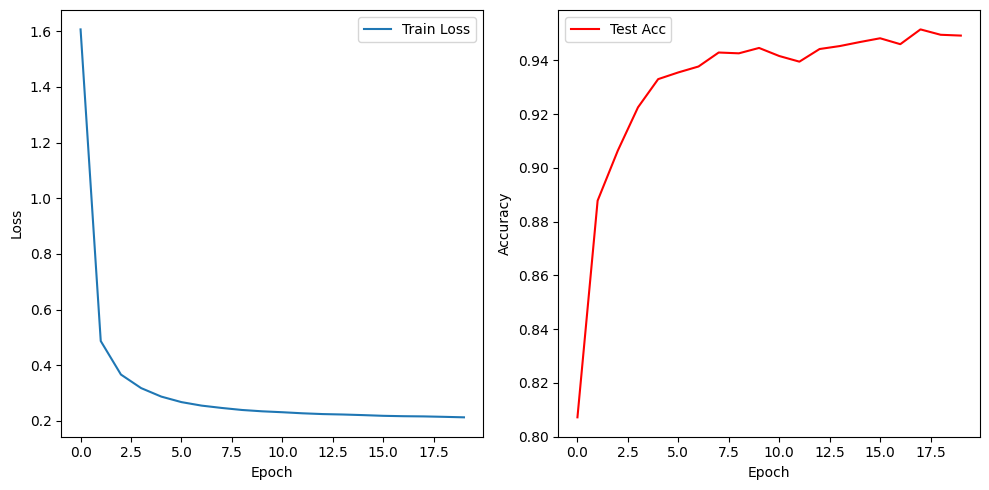

In [13]:
net = Net()
optimizer = torch.optim.SGD(net.parameters(), lr, weight_decay = 0.01)
train1(net, train_iter, loss, epochs, optimizer)

epoch 1, train loss 1.7667, train acc 0.364, test acc 0.787
epoch 2, train loss 0.6240, train acc 0.817, test acc 0.862
epoch 3, train loss 0.4907, train acc 0.867, test acc 0.879
epoch 4, train loss 0.4543, train acc 0.880, test acc 0.888
epoch 5, train loss 0.4254, train acc 0.889, test acc 0.895
epoch 6, train loss 0.4027, train acc 0.896, test acc 0.900
epoch 7, train loss 0.3883, train acc 0.900, test acc 0.903
epoch 8, train loss 0.3790, train acc 0.905, test acc 0.907
epoch 9, train loss 0.3702, train acc 0.907, test acc 0.912
epoch 10, train loss 0.3647, train acc 0.909, test acc 0.914
epoch 11, train loss 0.3605, train acc 0.911, test acc 0.901
epoch 12, train loss 0.3563, train acc 0.912, test acc 0.898
epoch 13, train loss 0.3543, train acc 0.913, test acc 0.918
epoch 14, train loss 0.3514, train acc 0.914, test acc 0.917
epoch 15, train loss 0.3491, train acc 0.915, test acc 0.920
epoch 16, train loss 0.3490, train acc 0.914, test acc 0.914
epoch 17, train loss 0.3458, trai

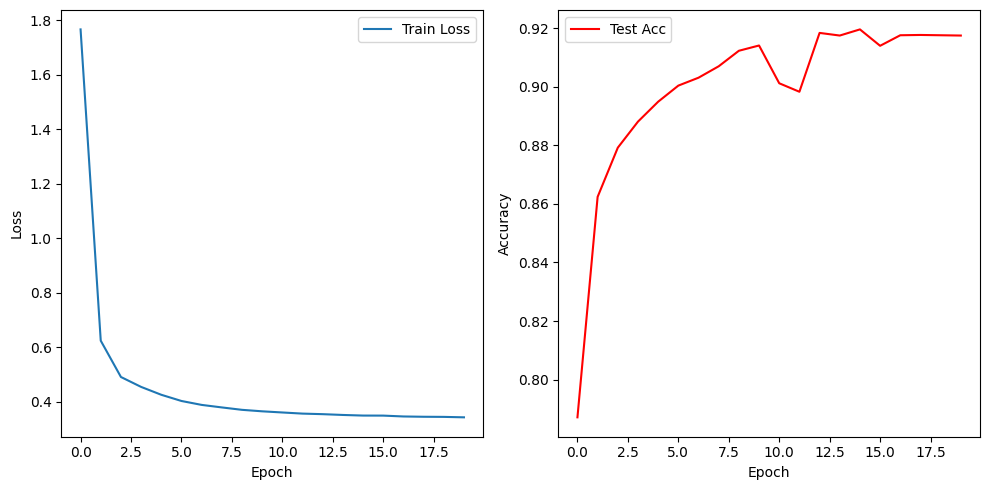

In [14]:
net = Net()
optimizer = torch.optim.SGD(net.parameters(), lr, weight_decay = 0.02)
train1(net, train_iter, loss, epochs, optimizer)

epoch 1, train loss 2.3004, train acc 0.113, test acc 0.114
epoch 2, train loss 2.1350, train acc 0.191, test acc 0.232
epoch 3, train loss 1.7534, train acc 0.292, test acc 0.375
epoch 4, train loss 1.5721, train acc 0.401, test acc 0.407
epoch 5, train loss 1.5276, train acc 0.411, test acc 0.404
epoch 6, train loss 1.5139, train acc 0.431, test acc 0.453
epoch 7, train loss 1.4972, train acc 0.448, test acc 0.468
epoch 8, train loss 1.4561, train acc 0.474, test acc 0.473
epoch 9, train loss 1.4385, train acc 0.489, test acc 0.488
epoch 10, train loss 1.4366, train acc 0.485, test acc 0.450
epoch 11, train loss 1.4271, train acc 0.487, test acc 0.488
epoch 12, train loss 1.3193, train acc 0.520, test acc 0.607
epoch 13, train loss 1.0532, train acc 0.635, test acc 0.671
epoch 14, train loss 1.0244, train acc 0.657, test acc 0.668
epoch 15, train loss 0.9899, train acc 0.673, test acc 0.743
epoch 16, train loss 0.8247, train acc 0.752, test acc 0.774
epoch 17, train loss 0.7760, trai

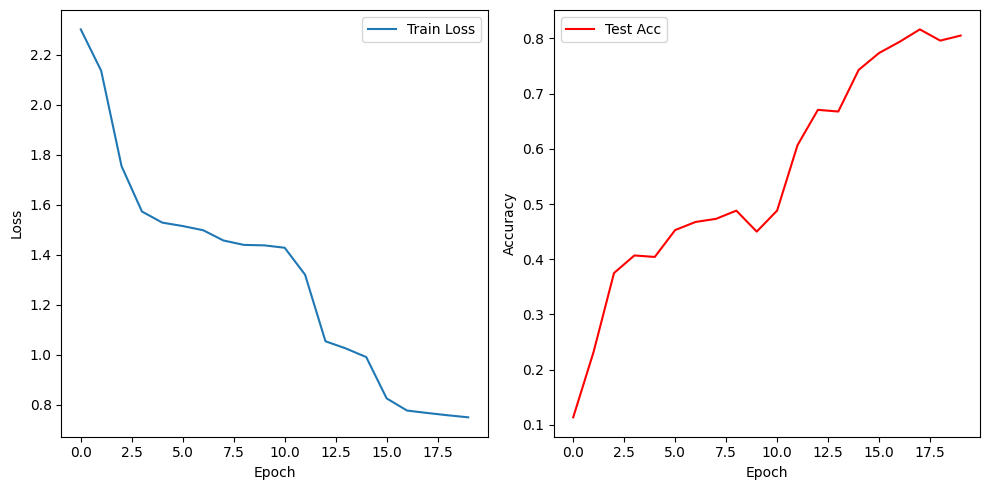

In [15]:
net = Net()
optimizer = torch.optim.SGD(net.parameters(), lr, weight_decay = 0.05)
train1(net, train_iter, loss, epochs, optimizer)